In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpxomyk5jm/pubring.gpg' created
gpg: /tmp/tmpxomyk5jm/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import sys
sys.path.append('drive/cyclegan_proj')

In [0]:
from loss import compute_loss
import networks as net
from data_sampler import data_sampler
from utl import *

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import clear_output

In [0]:
# checkpoint = torch.load("drive/cyclegan_proj/checkpoint_180228_065016.tar")
# discr_a = checkpoint.get('discr_a')
# discr_b = checkpoint.get('discr_b')
# gener_a = checkpoint.get('gener_a')
# gener_b = checkpoint.get('gener_b')
# opt_gener_a = checkpoint.get('opt_gener_a')
# opt_gener_b = checkpoint.get('opt_gener_b')
# opt_discr_a = checkpoint.get('opt_discr_a')
# opt_discr_b = checkpoint.get('opt_discr_b')

In [0]:
input_nc = 1
output_nc = 1
discr_filters = 24
max_power = 8
n_layers = 6
norm_lay = nn.InstanceNorm2d
start_size = 28
gen_filters = 32
dropout = 0.5
n_blocks = 4
batch_size = 15
alpha = 5

In [0]:
train_pull = pd.read_csv("drive/cyclegan_proj/train_pull.csv", 
                         header=None).values
train_top = pd.read_csv("drive/cyclegan_proj/train_top.csv",
                        header=None).values

In [0]:
discr_a = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size).cuda()

discr_b = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size).cuda()

gener_a = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
).cuda()

gener_b = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
).cuda()

In [11]:
gener_a.apply(weights_init)
gener_b.apply(weights_init)
discr_a.apply(weights_init)
discr_b.apply(weights_init)
print("weights initialized")

weights initialized


In [0]:
opt_gener_a = torch.optim.Adam(gener_a.parameters(), lr=0.001)
opt_gener_b = torch.optim.Adam(gener_b.parameters(), lr=0.001)
opt_discr_a = torch.optim.Adam(discr_a.parameters(), lr=0.001)
opt_discr_b = torch.optim.Adam(discr_b.parameters(), lr=0.001)

In [0]:
ga_loss_log = []
gb_loss_log = []
da_loss_log = []
db_loss_log = []

In [0]:
# discr_a.load_state_dict(checkpoint.get('discr_a'))
# discr_b.load_state_dict(checkpoint.get('discr_b'))
# gener_a.load_state_dict(checkpoint.get('gener_a'))
# gener_b.load_state_dict(checkpoint.get('gener_b'))
# opt_gener_a.load_state_dict(checkpoint.get('opt_gener_a'))
# opt_gener_b.load_state_dict(checkpoint.get('opt_gener_b'))
# opt_discr_a.load_state_dict(checkpoint.get('opt_discr_a'))
# opt_discr_b.load_state_dict(checkpoint.get('opt_discr_b'))

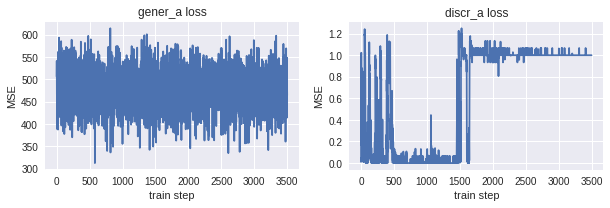

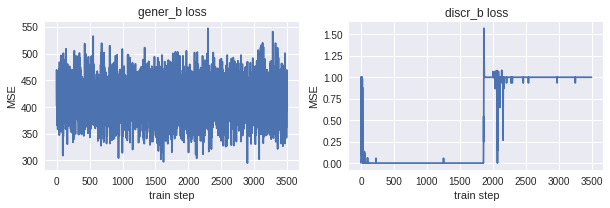

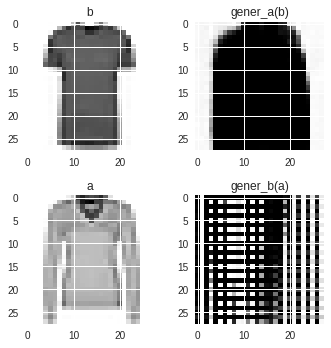

step 3600


In [0]:
for i in range(10000):
    batch_a, batch_b = data_sampler(batch_size, train_pull, train_top)
    batch_a = batch_a.view(-1, 1, 28, 28).float()
    batch_b = batch_b.view(-1, 1, 28, 28).float()
    gener_a.train()
    gener_b.train()
    discr_a.train()
    discr_b.train()
    
    da_loss, db_loss, ga_loss, gb_loss = compute_loss(gener_a, gener_b,
                                                      discr_a, discr_b,
                                                      batch_a, batch_b,
                                                      alpha)
    if i % 2 == 0:
        opt_discr_a.zero_grad()
        da_loss.backward(retain_graph=True)
        opt_discr_a.step()
        opt_discr_b.zero_grad()
        db_loss.backward()
        opt_discr_b.step()
    else:
        opt_gener_a.zero_grad()
        ga_loss.backward(retain_graph=True)
        opt_gener_a.step()
        opt_gener_b.zero_grad()
        gb_loss.backward()
        opt_gener_b.step()
    
    ga_loss_log.append(ga_loss.data[0])
    gb_loss_log.append(gb_loss.data[0])
    da_loss_log.append(da_loss.data[0])
    db_loss_log.append(db_loss.data[0])
    
    if (i+1) % 100 == 0:
      print("step {}".format(i+1))
    
    if (i+1) % 500 == 0:
      clear_output()
      plt.figure(figsize=(10, 6))

      plt.subplot(2, 2, 1)
      plt.plot(ga_loss_log)
      plt.title("gener_a loss")
      plt.xlabel("train step")
      plt.ylabel("MSE")

      plt.subplot(2, 2, 2)
      plt.plot(da_loss_log)
      plt.title("discr_a loss")
      plt.xlabel("train step")
      plt.ylabel("MSE")


      plt.figure(figsize=(10, 6))
      plt.subplot(2, 2, 1)
      plt.plot(gb_loss_log)
      plt.title("gener_b loss")
      plt.xlabel("train step")
      plt.ylabel("MSE")

      plt.subplot(2, 2, 2)
      plt.plot(db_loss_log)
      plt.title("discr_b loss")
      plt.xlabel("train step")
      plt.ylabel("MSE")
      plt.show()

      ind = np.random.randint(0, batch_size, 1, dtype=int)[0]
      sample_a, sample_b = data_sampler(1, train_pull, train_top)
      
      plt.figure(figsize=(5, 5))
      plt.tight_layout()

      plt.subplot(2, 2, 1)
      plt.imshow(sample_b.cpu().view(1, 1, 28, 28).data[0]
                 .numpy().reshape((28, 28)),
                 cmap='binary')
      plt.title("b")

      plt.subplot(2, 2, 2)
      plt.tight_layout()
      plt.imshow(gener_a(sample_b.view(1, 1, 28, 28)).cpu().data[0]
                 .numpy().reshape((28, 28)),
                 cmap='binary')
      plt.title("gener_a(b)")

      plt.subplot(2, 2, 3)
      plt.tight_layout()
      plt.imshow(sample_a.cpu().view(1, 1, 28, 28).data[0]
                 .numpy().reshape((28, 28)), 
                 cmap='binary')
      plt.title("a")

      plt.subplot(2, 2, 4)
      plt.tight_layout()
      plt.imshow(gener_b(sample_a.view(1, 1, 28, 28)).cpu().data[0]
                 .numpy().reshape((28, 28)),
                 cmap='binary')
      plt.title("gener_b(a)")

      plt.show()

In [0]:
state = create_checkpoint(discr_a, discr_b, gener_a, gener_b,
                          opt_gener_a, opt_gener_b, opt_discr_a, opt_discr_b)

In [0]:
torch.save(state, "drive/cyclegan_proj/checkpoint_{}.tar"
          .format(dt.datetime.now().strftime("%y%m%d_%H%M%S")))

In [0]:
# checkpoint = torch.load("drive/cyclegan_proj/checkpoint_180228_063123.tar")
# discr_a = checkpoint.get('discr_a')
# discr_b = checkpoint.get('discr_b')
# gener_a = checkpoint.get('gener_a')
# gener_b = checkpoint.get('gener_b')
# opt_gener_a = checkpoint.get('opt_gener_a')
# opt_gener_b = checkpoint.get('opt_gener_b')
# opt_discr_a = checkpoint.get('opt_discr_a')
# opt_discr_b = checkpoint.get('opt_discr_b')